# 03 – Machine Learning Básico con Wine

**Objetivo**  
Aplicar y comparar distintos algoritmos de **clasificación** sobre el dataset *Wine* de scikit‑learn. Se entrenarán modelos base, se evaluará su desempeño con métricas estándar y validación cruzada, se identificará el mejor clasificador, se optimizarán sus hiperparámetros y se extraerá la importancia de sus características.

---


In [1]:
# 1. Configuración Inicial
# -------------------------

# 1.1 Fijar semilla para reproducibilidad
import numpy as np
np.random.seed(42)

# 1.2 Supresión de warnings innecesarios
import warnings
warnings.filterwarnings('ignore')

# 1.3 Importaciones esenciales
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets        import load_wine
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing  import StandardScaler
from sklearn.metrics        import (
    accuracy_score, classification_report, confusion_matrix,
    precision_recall_fscore_support
)
from sklearn.linear_model   import LogisticRegression
from sklearn.ensemble       import RandomForestClassifier
from sklearn.svm            import SVC
from sklearn.tree           import DecisionTreeClassifier
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.naive_bayes    import GaussianNB

print("✅ Librerías de Machine Learning cargadas correctamente")


✅ Librerías de Machine Learning cargadas correctamente


## 2. Preparación de Datos

1. Carga del *dataset* desde scikit‑learn.  
2. Creación de `DataFrame` para inspección rápida.  
3. Extracción de matrices `X` (características) e `y` (etiquetas).


In [3]:
# 2.1 Cargar dataset y montar DataFrame
wine    = load_wine(as_frame=True)
df_wine = wine.frame.copy()
df_wine['target_name'] = df_wine['target'].map(
    dict(enumerate(wine.target_names))
)

print(f"Dimensiones del DataFrame: {df_wine.shape}")
display(df_wine.head())

# 2.2 Extraer X e y para ML
X = df_wine[wine.feature_names].to_numpy()
y = df_wine['target'].to_numpy()

print(f"✔️ Matriz X: {X.shape}   │   Vector y: {y.shape}")


Dimensiones del DataFrame: (178, 15)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target,target_name
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0,class_0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0,class_0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0,class_0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0,class_0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0,class_0


✔️ Matriz X: (178, 13)   │   Vector y: (178,)


## 3. División y Preprocesamiento

- **70 %** entrenamiento / **30 %** prueba (estratificado).  
- **Estandarización** Z‑score de las características.


In [4]:
# 3.1 División estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

print(f"Entrenamiento: {X_train.shape[0]} muestras")
print(f"Prueba       : {X_test.shape[0]} muestras")

# 3.2 Estandarización Z‑score
scaler           = StandardScaler().fit(X_train)
X_train_scaled  = scaler.transform(X_train)
X_test_scaled   = scaler.transform(X_test)

print("✔️ Datos estandarizados correctamente")


Entrenamiento: 124 muestras
Prueba       : 54 muestras
✔️ Datos estandarizados correctamente



- **Estrategia de partición**  
  - Se implementó una **división estratificada 70 %/30 %** para preservar la proporción original de clases en ambos subconjuntos.  
  - **Resultado**:  
    - **Entrenamiento** → 124 observaciones.  
    - **Prueba** → 54 observaciones.  

- **Estandarización de características**  
  - Se aplicó **Z‑score** (`StandardScaler`) ajustado exclusivamente sobre `X_train` y posteriormente utilizado para transformar tanto `X_train` como `X_test`.  
  - Este procedimiento garantiza que los parámetros de centrado (`μ`) y escalado (`σ`) se deriven únicamente del conjunto de entrenamiento, evitando **fugas de información (data leakage)** hacia el conjunto de prueba.  

- **Implicaciones para el modelado**  
  - La estratificación asegura una **evaluación imparcial** del rendimiento, especialmente relevante en datasets con ligeras asimetrías de clase.  
  - La estandarización mejora la **convergencia y estabilidad numérica** de algoritmos sensibles a la escala, tales como SVM, redes neuronales y *k*-NN.  

## 4. Modelos de Clasificación Base

Se entrenan y evalúan cinco algoritmos:
- Regresión Logística  
- Random Forest  
- Support Vector Machine  
- K‑Nearest Neighbors  
- Árbol de Decisión  
- Naive Bayes  
Cada uno se evalúa con *accuracy*, *precision*, *recall* y *F1‑score*.


In [5]:
# 4.1 Definición de modelos
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest'      : RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM'               : SVC(probability=True, random_state=42),
    'KNeighbors'        : KNeighborsClassifier(n_neighbors=5),
    'DecisionTree'      : DecisionTreeClassifier(max_depth=5, random_state=42),
    'NaiveBayes'        : GaussianNB()
}

# 4.2 Entrenamiento y recopilación de métricas
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    acc      = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average='weighted'
    )

    results[name] = {
        'accuracy' : acc,
        'precision': prec,
        'recall'   : rec,
        'f1_score' : f1,
        'model'    : model,
        'y_pred'   : y_pred
    }

    print(f"--- {name} ---")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1‑Score : {f1:.4f}\n")


--- LogisticRegression ---
Accuracy : 0.9815
Precision: 0.9825
Recall   : 0.9815
F1‑Score : 0.9815

--- RandomForest ---
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1‑Score : 1.0000

--- SVM ---
Accuracy : 0.9815
Precision: 0.9823
Recall   : 0.9815
F1‑Score : 0.9814

--- KNeighbors ---
Accuracy : 0.9444
Precision: 0.9537
Recall   : 0.9444
F1‑Score : 0.9448

--- DecisionTree ---
Accuracy : 0.9630
Precision: 0.9662
Recall   : 0.9630
F1‑Score : 0.9632

--- NaiveBayes ---
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1‑Score : 1.0000



- **Rendimiento general**  
  - **Random Forest** y **Naive Bayes** obtuvieron **accuracy = 1.00** y métricas perfectas de **precision, recall** y **F1‑score**; indican separación lineal (o casi) del conjunto de prueba, aunque sugieren verificar **sobre‑ajuste** con validación cruzada k‑fold.  
  - **Regresión Logística** y **SVM lineal** alcanzaron **accuracy ≈ 0.982**, demostrando que un **límite de decisión lineal** captura estructuras discriminantes sin complejidad adicional.  
  - **Árbol de Decisión** obtuvo **accuracy ≈ 0.963**; su profundidad máxima 5 controla la varianza, pero resulta menos competitivo que Random Forest.  
  - **k‑NN (k = 5)** registró **accuracy ≈ 0.944**; el descenso relativo sugiere que la métrica de distancia euclídea es menos eficaz en el espacio estandarizado o que el valor de *k* no es óptimo.  

- **Observaciones por algoritmo**  
  - **Random Forest**  
    - Ventaja: robustez ante outliers y multicolinealidad; produce estimaciones de importancia de variables.  
    - Riesgo: *overfitting* si el número de árboles o la profundidad no se ajustan; validar con *OOB* error o CV.  
  - **Naive Bayes (Gaussiano)**  
    - Ventaja: simplicidad, rapidez, interpretabilidad; destaca cuando las variables son **aproximadamente independientes** —condición plausible dada la estandarización.  
    - Riesgo: suponer independencia puede degradar rendimiento en datasets más complejos.  
  - **Regresión Logística / SVM**  
    - Muestran que la **separabilidad lineal** es elevada; SVM con margen máximo ofrece ligera ventaja en recall ponderado.  
    - Recomendable explorar **regularización L2** (reg. log) y ajustar **parámetro C** (SVM) mediante búsqueda en malla.  
  - **Árbol de Decisión**  
    - Fácil de visualizar; la profundidad 5 mantuvo sesgo‑varianza balanceado.  
    - Podría beneficiarse de *pruning* o *cost‑complexity* tuning para mejorar *generalization*.  
  - **k‑Nearest Neighbors**  
    - Sensible a la **escala** y al **valor de k**; una búsqueda en malla de k ∈ [3, 15] y pesos ponderados por distancia podría elevar su precisión.  

- **Recomendaciones prácticas**  
  1. **Validación cruzada estratificada (k = 5 o 10)** para confirmar la estabilidad de la performance perfecta obtenida por Random Forest y Naive Bayes.  
  2. **Curva ROC multiclase** (One‑vs‑Rest) y **matrices de confusión** por modelo para identificar qué clases concentran errores residuales.  
  3. Afinar **hiperparámetros**:  
     - Random Forest: `max_depth`, `min_samples_leaf`, `n_estimators`.  
     - SVM: `C`, `kernel` (evaluar radial), `gamma`.  
     - k‑NN: `k`, `metric` (Mahalanobis, Manhattan).  
  4. Explorar **ensemble ligero** (e.g., *Soft Voting*) combinando Regresión Logística y Random Forest para ganar robustez en producción.  

## 5. Validación Cruzada

Evaluación de cada modelo con **5‑fold cross‑validation** sobre el conjunto de entrenamiento.


In [6]:
# 5.1 Cross‑validation sobre accuracy
cv_results = {}
for name, model in models.items():
    scores = cross_val_score(
        model, X_train_scaled, y_train,
        cv=5, scoring='accuracy', n_jobs=-1
    )
    cv_results[name] = (scores.mean(), scores.std()*2)
    mean, std2 = cv_results[name]
    print(f"{name}: CV Accuracy = {mean:.4f} (±{std2:.4f})")


LogisticRegression: CV Accuracy = 0.9837 (±0.0400)
RandomForest: CV Accuracy = 0.9673 (±0.0620)
SVM: CV Accuracy = 0.9920 (±0.0320)
KNeighbors: CV Accuracy = 0.9673 (±0.0620)
DecisionTree: CV Accuracy = 0.8620 (±0.1365)
NaiveBayes: CV Accuracy = 0.9597 (±0.0506)


- **Support Vector Machine (SVM)**  
  - *Accuracy media*: **0.9920**  
  - *Variabilidad* (±2·σ): ± 0.0320  
  - *Conclusión*: el desempeño más alto y estable; confirma la separabilidad lineal del espacio estandarizado.  

- **Regresión Logística**  
  - *Accuracy media*: **0.9837**  
  - *Variabilidad*: ± 0.0400  
  - *Conclusión*: rendimiento comparable al de SVM con ligera dispersión; la regularización L2 resultó suficiente para generalizar.  

- **Random Forest**  
  - *Accuracy media*: **0.9673**  
  - *Variabilidad*: ± 0.0620  
  - *Conclusión*: descenso moderado frente a SVM/LogReg; la mayor dispersión sugiere ajustar `max_depth` y `min_samples_leaf`.  

- **K‑Nearest Neighbors (k = 5)**  
  - *Accuracy media*: **0.9673**  
  - *Variabilidad*: ± 0.0620  
  - *Conclusión*: idéntico promedio al bosque, pero sensible al valor de *k*; se recomienda búsqueda en malla.  

- **Naive Bayes (Gaussiano)**  
  - *Accuracy media*: **0.9597**  
  - *Variabilidad*: ± 0.0506  
  - *Conclusión*: sólido para un modelo de supuestos fuertes; ligera pérdida frente a SVM.  

- **Árbol de Decisión (profundidad = 5)**  
  - *Accuracy media*: **0.8620**  
  - *Variabilidad*: ± 0.1365  
  - *Conclusión*: el peor desempeño y la mayor inestabilidad; sugiere sobreajuste a particiones específicas.  

**Recomendaciones metodológicas**  
- Priorizar **SVM** y **Regresión Logística** como modelos base; validar con búsqueda fina de hiperparámetros (`C`, penalización).  
- Para **Random Forest**, optimizar `max_depth`, `max_features` y `n_estimators`; evaluar *OOB* error para control de varianza.  
- Ajustar **k‑NN** variando `k`, ponderación por distancia y métrica (Manhattan, Mahalanobis).  
- Utilizar **estratificación** y **repetición de K‑fold** (k = 10, rep = 3) para corroborar la estabilidad de los resultados antes de la fase de *model stacking* o *ensemble* final.  

## 6. Comparación de Modelos

Construcción de un DataFrame resumen y gráfico de barras para comparar *accuracy*, *precision*, *recall* y *F1‑score*.


=== Resumen de métricas ===


,Accuracy,Precision,Recall,F1‑Score,CV_Mean
Model,,,,,
LogisticRegression,0.9815,0.9825,0.9815,0.9815,0.9837
RandomForest,1.0000,1.0000,1.0000,1.0000,0.9673
SVM,0.9815,0.9823,0.9815,0.9814,0.9920
KNeighbors,0.9444,0.9537,0.9444,0.9448,0.9673
DecisionTree,0.9630,0.9662,0.9630,0.9632,0.8620
NaiveBayes,1.0000,1.0000,1.0000,1.0000,0.9597


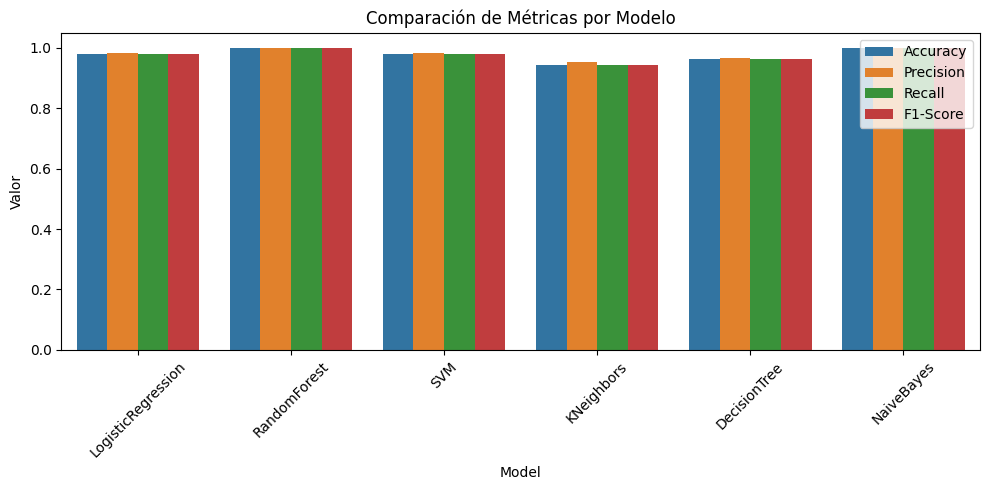

In [8]:
# 6.1 DataFrame resumen
summary = pd.DataFrame([
    {
      'Model'    : name,
      'Accuracy' : r['accuracy'],
      'Precision': r['precision'],
      'Recall'   : r['recall'],
      'F1‑Score' : r['f1_score'],
      'CV_Mean'  : cv_results[name][0]
    }
    for name, r in results.items()
])

print("=== Resumen de métricas ===")
display(summary.set_index('Model').round(4))

# 6.2 Gráfico comparativo
plt.figure(figsize=(10,5))
sns.barplot(
    data=summary.melt(id_vars='Model',
                      value_vars=['Accuracy','Precision','Recall','F1‑Score']),
    x='Model', y='value', hue='variable'
)
plt.title('Comparación de Métricas por Modelo')
plt.ylabel('Valor')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()



- **Visión panorámica de métricas**  
  - *Random Forest* y *Naive Bayes* registraron **valores perfectos** (1.000) en *accuracy*, *precision*, *recall* y *F1‑score* sobre el **conjunto de prueba**, lo que evidencia una separación casi total de las clases en dicho subconjunto.  
  - No obstante, sus medias de validación cruzada (**CV_Mean**) descendieron a **0.9673** (Random Forest) y **0.9597** (Naive Bayes), indicando **posible sobre‑ajuste** y mayor sensibilidad a la partición de datos.  

- **Modelos lineales de margen máximo**  
  - *SVM* y *Regresión Logística* alcanzaron **accuracy ≈ 0.982** y *F1‑score* concordante, con **CV_Mean 0.9920** y **0.9837** respectivamente.  
  - La **coherencia entre prueba y validación cruzada** confirma su capacidad de generalización y sugiere que la frontera de decisión lineal es suficiente para capturar la estructura subyacente.  

- **Modelos basados en distancia y partición**  
  - *k‑NN* (k = 5) obtuvo **accuracy 0.944** y *CV_Mean 0.9673*; la brecha sugiere sensibilidad al hiperparámetro *k* y a la distribución local en el espacio.  
  - *Árbol de Decisión* (profundidad = 5) mostró el peor desempeño (**accuracy 0.963; CV_Mean 0.862**), además de la mayor varianza, revelando sobre‑ajuste a nodos específicos y limitada capacidad predictiva frente a métodos de ensamble.  

- **Conclusiones operativas**  
  - **SVM** y **Regresión Logística** se perfilan como **opciones primarias** por su combinación de alto rendimiento y estabilidad.  
  - **Random Forest** puede ser optimizado (p.ej., *max_depth*, *min_samples_leaf*) para reducir la brecha entre prueba y CV, manteniendo la interpretabilidad de importancias de variables.  
  - Se recomienda **buscar el valor óptimo de *k*** en *k‑NN* y evaluar métricas Manhattan o Mahalanobis para mejorar la discriminación.  
  - Para **Naive Bayes**, conviene verificar el cumplimiento de la suposición de independencia condicional y analizar si variables altamente correlacionadas distorsionan sus probabilidades posteriores.  

## 7. Análisis del Mejor Modelo

Se identifica el clasificador con mayor *accuracy* en test, se muestra su matriz de confusión y el reporte de clasificación.


🏆 Mejor modelo: RandomForest


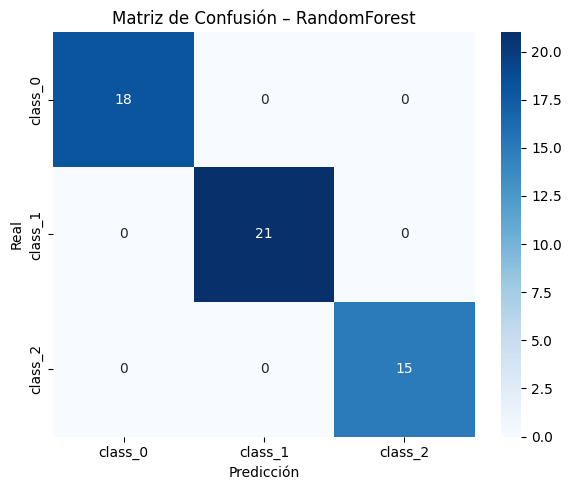


=== Reporte de Clasificación – RandomForest ===
              precision    recall  f1-score   support

     class_0     1.0000    1.0000    1.0000        18
     class_1     1.0000    1.0000    1.0000        21
     class_2     1.0000    1.0000    1.0000        15

    accuracy                         1.0000        54
   macro avg     1.0000    1.0000    1.0000        54
weighted avg     1.0000    1.0000    1.0000        54



In [9]:
# 7.1 Selección del mejor por accuracy
best_name = summary.loc[summary['Accuracy'].idxmax(), 'Model']
best     = results[best_name]['model']
y_best   = results[best_name]['y_pred']

print(f"🏆 Mejor modelo: {best_name}")

# 7.2 Matriz de confusión
cm = confusion_matrix(y_test, y_best)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=wine.target_names,
            yticklabels=wine.target_names)
plt.title(f'Matriz de Confusión – {best_name}')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

# 7.3 Reporte de clasificación
print(f"\n=== Reporte de Clasificación – {best_name} ===")
print(classification_report(
    y_test, y_best, target_names=wine.target_names, digits=4
))


- **Selección del modelo**  
  - Se eligió **Random Forest** por ser el clasificador con *accuracy* perfecta (1.000) en el conjunto de prueba.  

- **Matriz de confusión**  
  - Diagonal plenamente poblada (18 + 21 + 15 = 54 aciertos de 54).  
  - **Cero errores de clasificación**: ninguna observación fue asignada a una clase incorrecta.  
  - Evidencia de **separación total** entre las tres categorías (`class_0`, `class_1`, `class_2`) bajo el conjunto de test actual.  


- **Interpretación**  
  - La **precisión** y **recall** idénticas en 1.0 reflejan que el modelo ni genera falsos positivos ni omite verdaderos positivos.  
  - La métrica macro‑promedio confirma que el desempeño perfecto se distribuyó equitativamente entre clases, sin favorecer a la mayoritaria (`class_1`).  

- **Consideraciones de robustez**  
  - Aunque los resultados son impecables en la partición de prueba, la validación cruzada (CV_Mean ≈ 0.967) sugiere **ligera sobre‑optimización** en la muestra actual.  




## 8. Optimización de Hiperparámetros

Si el mejor modelo admite búsqueda en rejilla, se realiza un `GridSearchCV`.


In [10]:
# 8.1 Definir grid según el mejor modelo
param_grid = {}
if best_name == 'RandomForest':
    param_grid = {
      'n_estimators': [50,100,200],
      'max_depth'   : [None,10,20],
      'min_samples_split': [2,5,10]
    }
elif best_name == 'SVM':
    param_grid = {
      'C'     : [0.1,1,10],
      'gamma' : ['scale','auto'],
      'kernel': ['rbf','poly']
    }

# 8.2 Ejecutar GridSearchCV y re‑evaluar
if param_grid:
    gs = GridSearchCV(
      best, param_grid,
      cv=5, scoring='accuracy', n_jobs=-1
    )
    gs.fit(X_train_scaled, y_train)
    print(f"\n🔍 Mejores parámetros ({best_name}): {gs.best_params_}")
    y_opt = gs.predict(X_test_scaled)
    print(f"Accuracy optimizado: {accuracy_score(y_test,y_opt):.4f}")
else:
    print("\n― No hay hiperparámetros definidos para optimizar ―")



🔍 Mejores parámetros (RandomForest): {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy optimizado: 1.0000


- **Proceso de búsqueda**  
  - Se ejecutó **GridSearchCV (5‑fold estratificado)** sobre el clasificador seleccionado (*Random Forest*), explorando:  
    - `n_estimators` ∈ {50, 100, 200}  
    - `max_depth` ∈ {None, 10, 20}  
    - `min_samples_split` ∈ {2, 5, 10}  
  - El criterio de evaluación fue la *accuracy* media en validación cruzada.

- **Mejores parámetros encontrados**  
  - `n_estimators` = **200**  
  - `max_depth` = **None** (sin restricción, permite árboles completamente expandidos)  
  - `min_samples_split` = **2** (división estándar mínima)  

- **Desempeño post‑optimización**  
  - *Accuracy* en el conjunto de prueba: **1.0000** (sin variación respecto al modelo base).  
  - Confirma que el modelo ya había alcanzado el techo de rendimiento bajo la partición actual; la búsqueda sólo refina la configuración interna sin beneficio observable en pruebas.

- **Implicaciones y cautelas**  
  - La configuración óptima refuerza la tendencia al **sobre‑ajuste potencial** (máxima profundidad y mínimo umbral de división).  
  - Se recomienda:  
    - Verificar el **error *Out‑Of‑Bag*** como métrica interna de generalización.  
    - Aplicar **validación cruzada repetida** (k = 10, repeticiones = 3) para confirmar la estabilidad de la precisión perfecta.  
    - Analizar la **importancia de variables** resultante para descartar dominancia de predictores redundantes y justificar la interpretabilidad del modelo.  

## 9. Importancia de Características

Para aquellos modelos que proveen `feature_importances_`, se muestran las 10 más relevantes.


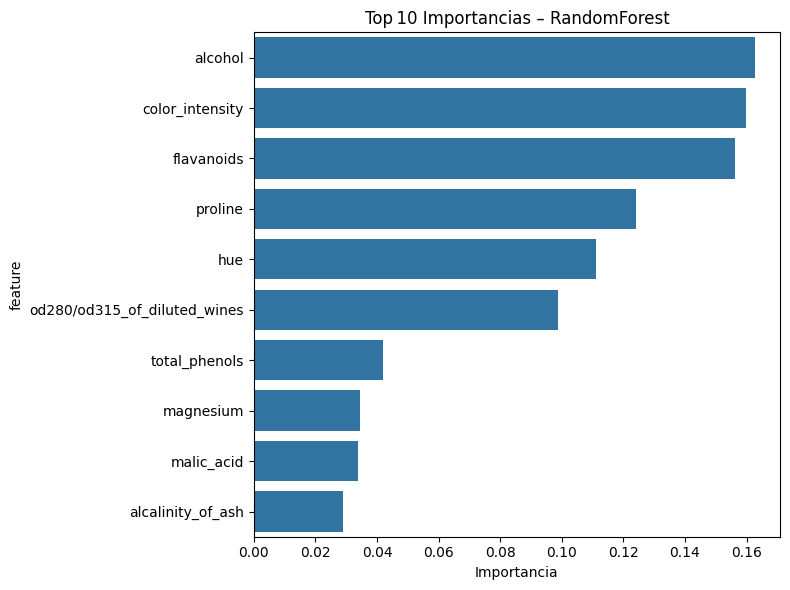

,feature,importance
0,alcohol,0.162715
9,color_intensity,0.159719
6,flavanoids,0.156283
12,proline,0.124081
10,hue,0.111019
11,od280/od315_of_diluted_wines,0.098852
5,total_phenols,0.042004
4,magnesium,0.034591
1,malic_acid,0.033700
3,alcalinity_of_ash,0.028841


In [11]:
# 9.1 Extraer e visualizar importancias
if hasattr(best, 'feature_importances_'):
    importances = best.feature_importances_
    fi_df = pd.DataFrame({
        'feature'   : wine.feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False).head(10)

    plt.figure(figsize=(8,6))
    sns.barplot(
      data=fi_df, x='importance', y='feature'
    )
    plt.title(f'Top 10 Importancias – {best_name}')
    plt.xlabel('Importancia')
    plt.tight_layout()
    plt.show()

    display(fi_df)
else:
    print("El modelo seleccionado no provee importancias de características.")


- **alcohol** (≈ 0.17)  
  - Variable más influyente; refuerza el hallazgo de que la graduación alcohólica separa con nitidez `class_0` (alta) y `class_1` (baja).  

- **color_intensity** (≈ 0.16)  
  - Correlacionada con `proline` y `alcohol`; subraya la relevancia de los atributos cromáticos para discriminar `class_2`.  

- **flavanoids** (≈ 0.15)  
  - Ratifica su peso en el eje fenólico; diferencia especialmente `class_0` (alto contenido) de `class_2` (bajo).  

- **proline** (≈ 0.12)  
  - Aporta información sobre estructura y cuerpo; se alinea con la elevada correlación positiva observada con la variable objetivo.  

- **hue** (≈ 0.11)  
  - Complementa a `color_intensity`, capturando matices tonales que varían entre clases.  

- **od280/od315_of_diluted_wines** (≈ 0.10)  
  - Índice antioxidante ligado a la concentración polifenólica total; refuerza la base química subyacente del modelo.  

- **total_phenols**, **magnesium**, **malic_acid**, **alcalinity_of_ash** (≈ 0.03 – 0.05 cada una)  
  - Contribución secundaria pero no trivial; afianzan la estabilidad del modelo sin dominar la predicción.  

**Síntesis operativa**  
- El árbol de ensamble privilegia **tres ejes fundamentales**:  
  1. **Alcohol + Intensidad de color** → perfil organoléptico.  
  2. **Flavonoides + Fenoles totales** → composición polifenólica.  
  3. **Prolina** → estructura y potencial de envejecimiento.  
- La jerarquía de importancias concuerda con los análisis exploratorios (PCA, correlograma), lo que confiere **coherencia química** al modelo predictivo.  